In [5]:
# IMPORTS
%load_ext autoreload
%autoreload 2
import healpy as hp
import numpy as np
import numpy.lib.recfunctions
import scipy.interpolate
import scipy.optimize
import scipy.stats
import matplotlib.pyplot as plt
import time
from __future__ import print_function
import xml.etree.ElementTree as et
from healpix_unfold import *
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from chris_colors import *

In [3]:
# CREATE SKYMAP
# initialize empty maps
nside = 4
npix = hp.pixelfunc.nside2npix(nside) 
TSs = np.zeros(npix, dtype=np.float)
pixrange = np.arange(npix)

# Convert to "nested" ordering so pixels from the same rhombic face are together
pixrange = hp.nest2ring(nside, pixrange)

# create coordinate grid
# NOTE: theta is NOT in local coordinates, but equatorial

theta, ra = hp.pixelfunc.pix2ang(nside, pixrange)
# turn from zenith to declination
dec = np.pi/2 - theta

In [4]:
# Face mid points
theta_mid, ra_mid = hp.pixelfunc.pix2ang(1, np.arange(12))
dec_mid = np.pi/2 - theta_mid

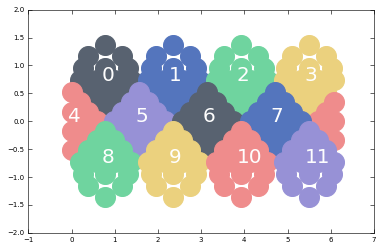

In [5]:
plt.clf()
for i_side in range(0,12):
    i_low,i_high = (nside**2 * i_side, nside**2 * (i_side+1))
    
    ra_i = ra[i_low:i_high]
    dec_i = dec[i_low:i_high]
    plt.scatter(ra_i,dec_i,color=myColors[i_side%6],s=400)
    
    
    plt.text(ra_mid[i_side]-0.1,dec_mid[i_side],str(i_side),color='white',size=20)
    #neighbours = hp.get_all_neighbours(nside,ipix)
    #plt.scatter(ra[neighbours],dec[neighbours],color='r',s=30)
plt.show()

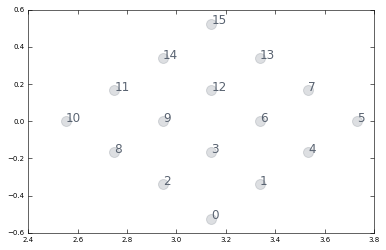

In [6]:
plt.clf()
for i_side in range(0,12)[6:7]:
    i_low,i_high = (nside**2 * i_side, nside**2 * (i_side+1))
    
  
    plt.scatter(ra[i_low:i_high],dec[i_low:i_high],color=myColors[i_side%6],alpha=0.2,s=100)
    
    for i,i_pix in enumerate(range(i_low,i_high,1)):
        plt.text(ra[i_pix],dec[i_pix],str(i_pix - i_low),color=myColors[i_side%6],size=12)
        
    
plt.show()

In [7]:
# It's a binary ordering:
# One square is
# 10 11
# 00 01
# Where "00" is the south/north corner (in declination/theta)
# Then it's divided => four child-pixels:
# - keep bits of parent
# - append two bits for relative position
# For "nested ordering" pixel number: add side index (starting at 0)

In [6]:
def little_endian_bits(n):
    return map(int,[s for s in bin(n)[2:]])

def quad_division(b):
    pos = [0,0]
    for i in range(len(b)):
        pos[i%2] += b[-(i+1)] * 2**(i/2)
    return pos
def position(n):
    return quad_division(little_endian_bits(n))

In [10]:
facepix = 4**2
pixelface = np.array(map(position,np.arange(facepix)))

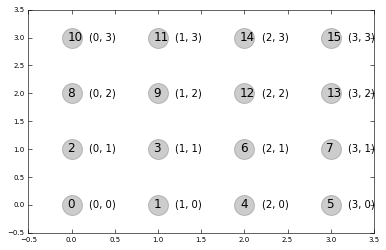

In [11]:
plt.clf()
plt.scatter(pixelface[:,0],pixelface[:,1],color='k',alpha=0.2,s=400)
for i in range(facepix):
    x,y = pixelface[i,0],pixelface[i,1]
    plt.text(x+.2,y-.05,str((x,y)),size=10)
    plt.text(x-.05,y-.05,str(i),size=12)
    

In [12]:
%%timeit
facepix = 512**2
pixelface = np.array(map(position,np.arange(facepix)))

1 loops, best of 3: 2.62 s per loop


In [5]:
skymap = np.load('skymap.npy')
nside = int(np.sqrt(skymap.size/12))
squares = skymap_to_squares(nside,skymap)
hp.mollview(skymap)

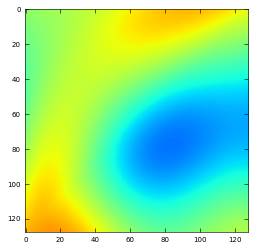

In [83]:
plt.clf()
for i,s in enumerate(squares):
    #plt.subplot(3,4,i+1)
    plt_file = 'test_healpix_squares_%i.svg'%i
    face_file = 'test_healpix_face_%i.svg'%i
    plt.imshow(s,vmin=skymap.min(),vmax=skymap.max())
    plt.savefig(plt_file,dpi=240)
    convert_matshow_to_rhombus(plt_file, face_file, i+1)

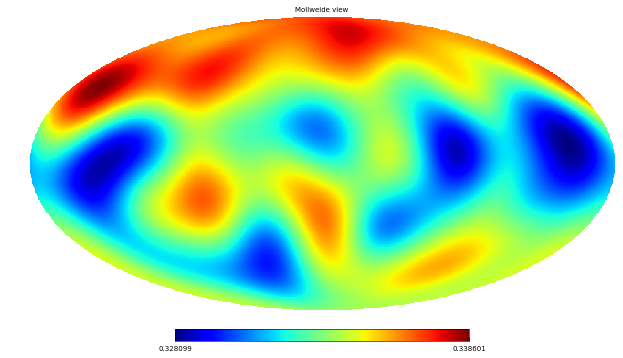

In [86]:
hp.mollview(skymap)

In [48]:
def center_of_path(d_line):
    import svg
    import svg.path
    from svg.path import parse_path
    rhombus_path=parse_path(d_line)
    x,y,n = 0,0,0
    for line in rhombus_path:
        c = line.start
        x += c.real
        y += c.imag
        n += 1
    return x/n,y/n
def trace_of_path(d_line):
    import svg
    import svg.path
    from svg.path import parse_path
    rhombus_path=parse_path(d_line)
    x,y,n = [],[],0
    for line in rhombus_path:
        c = line.start
        x += [c.real]
        y += [c.imag]
        n += 1
    if n==4:
        return x,y
    else:
        return [],[]

In [30]:
xarr = []
yarr = []
outfile = open('coordinate_text','w')
tree = et.parse('Rhombicdodecahedron_net.svg')
root = tree.getroot()
npath = 0
for path in root.iter('{http://www.w3.org/2000/svg}path'):
    npath += 1
    coord_line = path.get('d')
    x,y = center_of_path(coord_line)
    text_element = r"""      <text
         xml:space="preserve"
         style="font-style:normal;font-variant:normal;font-weight:normal;font-stretch:normal;font-size:16px;line-height:100%;font-family:'Fira Sans';-inkscape-font-specification:'Fira Sans';letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;stroke-width:1px;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:100000;stroke-opacity:1"
         x="{0:.3f}"
         y="{1:.3f}"
         id="text3743"><tspan
           sodipodi:role="line"
           id="tspan3741"
           style="stroke-linecap:butt;stroke-linejoin:round;stroke-miterlimit:100000"
           x="{0:.3f}"
           y="{1:.3f}">({0:.3f},{1:.3f})</tspan></text>""".format(x,y)
    xarr.append(x)
    yarr.append(y)
    outfile.write(text_element)
    #print(npoint,coord_type,x/npoint,y/npoint)
outfile.close()
    

In [49]:
xarr = []
yarr = []
tree = et.parse('Rhombicdodecahedron_net.svg')
root = tree.getroot()
npath = 0
for path in root.iter('{http://www.w3.org/2000/svg}path'):
    npath += 1
    coord_line = path.get('d')
    x,y = trace_of_path(coord_line)
    xarr+=x
    yarr+=y

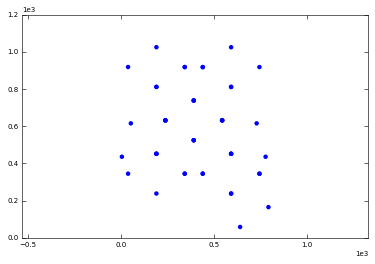

In [55]:
xarr = np.array(xarr)
yarr = np.array(yarr)
plt.scatter(xarr,yarr)
plt.axes().set_aspect('equal', 'datalim')

In [4]:
import xml.etree.ElementTree as et
tree = et.parse('Rhombicdodecahedron_net.svg')
root = tree.getroot()
npath = 0
for path in root.iter('{http://www.w3.org/2000/svg}path'):
    npath += 1
    coord_line = path.get('d')
    print coord_line
    

M 239.51633,631.37974 391.89788,738.04682 544.27942,631.37974 391.89788,524.71266 Z
M 239.20849,631.3329 391.56032,524.62338 343.4436,344.94928 191.09179,451.65879 Z
M 239.05919,631.60614 190.89244,451.94547 5.5971324,435.70821 53.763889,615.3689 Z
M 38.741806,344.64399 191.12333,451.31107 343.50488,344.64399 191.12333,237.97692 Z
M 440.35214,917.81009 592.70397,811.10067 544.58726,631.42658 392.23543,738.13609 Z
m 239.2085,631.42658 -48.1167,179.67409 152.35182,106.70962 48.11672,-179.6742 z
M 38.741806,918.1155 191.12333,1024.7825 343.50488,918.1155 191.12333,811.44841 Z
M 440.35214,344.94929 392.23543,524.62338 544.58726,631.3329 592.70397,451.65879 Z
M 778.19864,435.7082 592.90332,451.94545 544.73657,631.60614 730.03186,615.3689 Z
M 440.29088,344.64399 592.67241,451.31107 745.05396,344.64399 592.67241,237.97692 Z
M 641.12669,58.213528 593.00997,237.88764 745.36179,344.59715 793.4785,164.92304 Z
M 440.35214,917.81009 592.73369,1024.4772 745.11523,917.81009 592.73369,811.14301 Z


In [119]:
x = 10
"{0:.3f}".format(x)

'10.000'

In [22]:
c.imag

524.71266

In [32]:
raw_centers = """11(391.898,631.380)
8(291.326,488.141)
3(122.328,533.657)
4(191.123,344.644)
10(492.470,774.618)
7(291.326,774.618)
2(191.123,918.115)
12(492.470,488.141)
9(661.468,533.657)
5(592.672,344.644)
1(693.244,201.405)
6(592.734,917.810)""".split()

In [35]:
coordinates = {}
for rc in raw_centers:
    i = int(rc.split('(')[0])
    xy = rc.split('(')[1][:-1].split(',')
    x = float(xy[0])
    y = float(xy[1])
    coordinates[i] = (x,y)
    

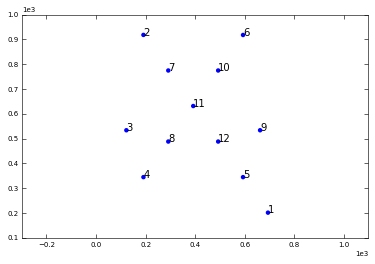

In [54]:
for i,(x,y) in coordinates.items():
    plt.scatter(x,y)
    plt.text(x,y,str(i))
plt.axes().set_aspect('equal', 'datalim')



In [43]:
rotations = {1: 20,
2: 90,
3: 50,
4: 90,
5: 0,
6: 180,
7: 110,
8: 70,
9: -50,
10: 160,
11: 90,
12: 20}

In [69]:
# The coordinates of the images are before the transform
# So 0,0 corresponds to their south corner
# 1) Determine the south corner of each face
south_corner = {}
for i in range(1,13):
    x_ctr,y_ctr = coordinates[i]
    height_scale = [305.525,214.096][i in [5,6,7,8]]
    a = rotations[i]
    x_south = x_ctr + height_scale*np.sin(np.radians(a))/2.
    y_south = y_ctr + height_scale*np.cos(np.radians(a))/2.
    south_corner[i] = x_south,y_south

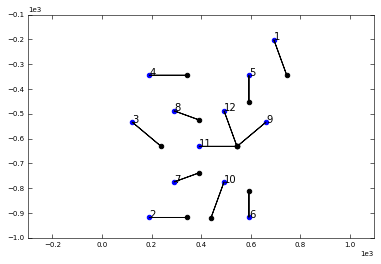

In [70]:
for i in coordinates.keys():
    x,y = coordinates[i]
    x_south,y_south = south_corner[i]
    
    
    plt.scatter(x,-y,color='b')
    plt.scatter(x_south,-y_south,color='k')
    plt.text(x,-y,str(i))
    plt.arrow(x, -y, x_south-x, -y_south+y, head_width=0.05, head_length=0.1, fc='k', ec='k')
    
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('network.svg')


In [13]:
template_stretched = parse_template_file('Rhombicdodecahedron_net_stretched_pure_template.svg')

In [15]:
import cPickle
with open('template_stretched.pkl','w') as f:
    cPickle.dump(template_stretched,f)

In [40]:
plt.clf()
image_tags = ""
for i,s in enumerate(squares):
    #plt.subplot(3,4,i+1)
    plt_file = 'test_healpix_squares_%i.svg'%i
    #plt.imshow(s,vmin=skymap.min(),vmax=skymap.max())
    #plt.savefig(plt_file,dpi=240)
    template = template_stretched[i+1]
    image_tags += convert_matshow_to_template(plt_file, **template)
encapsulate_in_svg(image_tags,'fourth_try_at_all_together.svg')

In [108]:
template

{'height': '186.48625',
 'id': 'image1',
 'transform': 'matrix(-0.81907582,-0.57368528,0.25869069,-0.96596021,0,0)',
 'width': '187.48621',
 'x': '-861.71582',
 'y': '154.60429'}

In [11]:
tree = et.parse('test_healpix_squares_11.svg')

root = tree.getroot()

for image in root.iter('{http://www.w3.org/2000/svg}image'):

    image_id = image.get('id')
    print (image_id)
    print(image.attrib.keys())


image0f506ed94a
['{http://www.w3.org/1999/xlink}href', 'width', 'y', 'x', 'id', 'height']
